<a href="https://www.kaggle.com/code/rupify/dogs-vs-cats-ipynb?scriptVersionId=260387020" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Dog vs Cat Classification using Pretrained ResNet-101

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import warnings

In [7]:
from torch.utils.data import DataLoader, random_split


In [2]:
from PIL import Image, UnidentifiedImageError
warnings.filterwarnings("ignore", category=UserWarning)


1. Device Configuration

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Transforming the images

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

 Safe Loader used:(skipping the corrupted images)

In [5]:
def safe_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f).convert("RGB")
        return img
    except (UnidentifiedImageError, OSError):
        return Image.new("RGB", (224, 224))

Dataset & DataLoader

In [8]:
data_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

full_dataset = datasets.ImageFolder(root=data_dir,
                                    transform=data_transform,
                                    loader=safe_loader)

train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

Train size: 20000, Validation size: 5000


Load Pretrained ResNet-101

In [9]:
model = models.resnet101(pretrained=True)


for param in model.parameters():
    param.requires_grad = False


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 181MB/s]  


Loss & optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Training the Model

In [11]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Acc: {train_acc:.2f}%")

Epoch [1/5], Loss: 0.0795, Acc: 97.17%
Epoch [2/5], Loss: 0.0456, Acc: 98.33%
Epoch [3/5], Loss: 0.0429, Acc: 98.39%
Epoch [4/5], Loss: 0.0436, Acc: 98.44%
Epoch [5/5], Loss: 0.0388, Acc: 98.59%


Evaluating the Model

In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 98.98%


Visualize Predictions

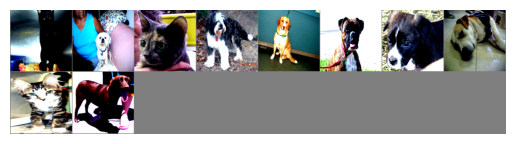

Actual:  Cat Dog Cat Dog Dog Dog Dog Dog Cat Dog
Predicted:    Cat Dog Cat Dog Dog Dog Dog Dog Cat Dog


In [14]:

classes = ['Cat', 'Dog']

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


outputs = model(images[:10])
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:10].cpu()))

print('Actual: ', ' '.join(classes[labels[j]] for j in range(10)))
print('Predicted:   ', ' '.join(classes[predicted[j]] for j in range(10)))